In [2]:
# Dataset: Amazon Books Reviews
# Author: Mohamed Bekheet
# Source: Mohamed Bekheet. (2022). Amazon Books Reviews [Data set]. Kaggle. https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
# URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
# This dataset contains 2 files
# The first file** reviews** file contain feedback about 3M user on 212404 unique books the data set is 
# part of the Amazon review Dataset it contains product reviews and metadata from Amazon, including 
# 142.8 million reviews spanning May 1996 - July 2014.
# Reviews Dataset Data Dictionary:
# -id:                  The Id of Book
# -Title:   	        Book Title
# -Price:               The price of Book
# -User_id:             Id of the user who rates the book
# -profileName:         Name of the user who rates the book
# -review/helpfulness:  helpfulness rating of the review, e.g. 2/3
# -review/score:        rating from 0 to 5 for the book
# -review/time:         time of given the review
# -review/summary:      the summary of a text review
# -review/text:         the full text of a review

# The second file Books Details file contains details information about 212404 unique books it file is built by using
# google books API to get details information about books it rated in the first file
# and this file contains

# Book Details Dataset Data Dictionary:
# Title:	        Book Title
# Descripe:	        Decription of book
# authors:	        Name of book authors
# image:	        Url for book cover
# previewLink:	    Link to access this book on google Books
# publisher:	    Name of the publisheer
# publishedDate:	The date of publish
# infoLink:	        Link to get more information about the book on google books
# categories:	    Genres of books
# ratingsCount:	    Averaging rating for book

# Both Datasets are linked through the unique tittle of the book.

In [3]:
# Step 0. Load libraries and custom modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re
from dateutil.parser import parse
from datetime import datetime
# ------------  PREPROCESING -------------
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
#-------------- TRANSFORMERS --------------
import transformers
from transformers.pipelines import PIPELINE_REGISTRY
from transformers import pipeline
import evaluate
from evaluate import load
from transformers import Conversation
transformers.logging.set_verbosity_error()

/home/arnaldochm/Documents/BootCamp_DataScience/Final_Project/final_project_nlp/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-22 08:35:05.303114: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-22 08:35:05.317325: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-22 08:35:05.384666: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-22 08:35:05.385919: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimize

In [4]:
#Loading the Datasets
df_rating_raw = pd.read_csv('../data/raw/Books_rating.csv')

df_rating_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  object 
 1   Title               object 
 2   Price               float64
 3   User_id             object 
 4   profileName         object 
 5   review/helpfulness  object 
 6   review/score        float64
 7   review/time         int64  
 8   review/summary      object 
 9   review/text         object 
dtypes: float64(2), int64(1), object(7)
memory usage: 228.9+ MB


In [5]:
df_rating_raw.sample(10)

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
1050571,1589971558,Redeeming Halloween: Celebrating without Selli...,NaN,AUM6TI6UYGIP3,BeautifulNBlessed,10/14,1.0,1262390400,Good Intentions - Bad Message! Consider this ....,I will start off by saying that I love Focus o...
1316598,B000KT8J86,Cunningham's Encyclopedia of Magical Herbs,NaN,NaN,NaN,0/0,4.0,1053820800,Cunningham was quite the herbalist,This is one of those books that you pick up al...
367300,B0007BF926,Reasons for disbelief: A survey of the histori...,NaN,AIBZW16CQPCN9,Peter F. Elliott,1/1,3.0,1111363200,author's comments,I actually wrote this book 25 years ago and am...
2181927,1578152704,Little Lord Fauntleroy,NaN,A3F8P7XLS7D1RX,Lynda Mattison,2/2,5.0,1360022400,A Timeless Story,"I had never read Little Lord Fauntleroy, and a..."
2142197,B000EJ6M68,Great Expectations,NaN,NaN,NaN,0/0,5.0,940032000,More high schoolers should read this book.,More high school students should read this boo...
1433533,B000NSFEXW,Babylon Rising: The Europa Conspiracy -w/o Nor...,NaN,AQXLHUIPS54TZ,Gloria Polson,0/0,4.0,1361232000,Typo's,"I would recommend this book, it helps one to s..."
1633738,B0006AU8K6,Lord of the Flies,NaN,A1HHBDLSCHK4M7,Nicole,0/0,3.0,985132800,cool book,I think the author was trying to say that with...
1168985,B0000YSH4W,The Giver,NaN,NaN,NaN,0/0,5.0,1115164800,The Giver,The Giver is a great book and goes into alot o...
2976114,B000Q032UY,The Hobbit or There and Back Again,NaN,A1EZ1D5V14AUAO,"D. Jones ""DJ""",2/6,3.0,1114646400,My Review of the Hobbit,The epic journey of a fat little old hobbit na...
913443,B000IOHQKA,Catch 22 (catch-22),NaN,AAKSF1IE35YOM,srs mn,0/5,5.0,1244073600,A Big Help For a Reading Assignment,The audio book made a required reading assignm...


In [6]:
#Load Books Data Dataset
df_data_raw = pd.read_csv('../data/raw/books_data.csv')

df_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212404 entries, 0 to 212403
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Title          212403 non-null  object 
 1   description    143962 non-null  object 
 2   authors        180991 non-null  object 
 3   image          160329 non-null  object 
 4   previewLink    188568 non-null  object 
 5   publisher      136518 non-null  object 
 6   publishedDate  187099 non-null  object 
 7   infoLink       188568 non-null  object 
 8   categories     171205 non-null  object 
 9   ratingsCount   49752 non-null   float64
dtypes: float64(1), object(9)
memory usage: 16.2+ MB


In [7]:
df_data_raw.sample(10)

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
150999,Pre Math It: Do It With Dominoes,This bold and colorful counting book shows you...,['Lynette Long'],http://books.google.com/books/content?id=0m_rx...,http://books.google.com/books?id=0m_rx1iqNmIC&...,Charlesbridge Publishing,1996-02-01,http://books.google.com/books?id=0m_rx1iqNmIC&...,['Juvenile Nonfiction'],1.0
51841,"Mandie and the Silent Catacombs (Mandie, Book 16)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
655,"Chicken, Shadow, Moon & More",A book of lists written in prose reflects the ...,['Mark Strand'],http://books.google.com/books/content?id=YF5bA...,http://books.google.nl/books?id=YF5bAAAAMAAJ&q...,Turtle Point,2000,http://books.google.nl/books?id=YF5bAAAAMAAJ&d...,['Poetry'],NaN
40477,Language And Deed.Rediscovering Politics throu...,This book examines Heidegger's controversial r...,['Frank Schalow'],http://books.google.com/books/content?id=uZ9PC...,http://books.google.com/books?id=uZ9PCHg_6y4C&...,Rodopi,1998,https://play.google.com/store/books/details?id...,['Philosophy'],NaN
165473,Mr. Bunny's Guide to ActiveX,NaN,['Gary Swanberg'],NaN,http://books.google.com/books?id=dAoOAQAACAAJ&...,NaN,1997-11-01,http://books.google.com/books?id=dAoOAQAACAAJ&...,NaN,NaN
133024,"Houseworks: Cut the Clutter, Speed Your Cleani...",Presents practical tips and strategies designe...,['Cynthia Townley Ewer'],http://books.google.com/books/content?id=5TMoA...,http://books.google.com/books?id=5TMoAAAACAAJ&...,Dk Pub,2006,http://books.google.com/books?id=5TMoAAAACAAJ&...,['House & Home'],1.0
82342,Over Goal: What You Must Know to Excel at Fund...,NaN,['Kay Sprinkel Grace'],http://books.google.com/books/content?id=Do9Ox...,http://books.google.com/books?id=Do9OxTrWDOIC&...,"Emerson & Church, Publishers",2006,http://books.google.com/books?id=Do9OxTrWDOIC&...,['Business & Economics'],NaN
102601,Kamehameha: The Boy Who Became a Warrior King,Chronicles the life of King Kamehameha I from ...,['Ellie Crowe'],http://books.google.com/books/content?id=8eEJP...,http://books.google.com/books?id=8eEJPwAACAAJ&...,NaN,2009-01-23,http://books.google.com/books?id=8eEJPwAACAAJ&...,['Juvenile Nonfiction'],NaN
9546,50 Years of the Gibson Les Paul (Softcover),The British Library is the UK's national libra...,"['British Library', 'British Library Staff']",http://books.google.com/books/content?id=keDgA...,http://books.google.nl/books?id=keDgAAAAMAAJ&q...,NaN,2003,http://books.google.nl/books?id=keDgAAAAMAAJ&d...,NaN,NaN
76376,Inside High School Reform: Making the Changes ...,What happens when some of the lowest-performin...,"['Jordan Horowitz', 'California Academic Partn...",http://books.google.com/books/content?id=uEBqz...,http://books.google.com/books?id=uEBqzx2Iad8C&...,WestEd,2005,http://books.google.com/books?id=uEBqzx2Iad8C&...,['Education'],NaN


In [8]:
#Revisar Valores Nulos
df_rating_raw.isna().sum()

Id                          0
Title                     208
Price                 2518829
User_id                561787
profileName            561905
review/helpfulness          0
review/score                0
review/time                 0
review/summary            407
review/text                 8
dtype: int64

In [9]:
df_data_raw.isna().sum()

Title                 1
description       68442
authors           31413
image             52075
previewLink       23836
publisher         75886
publishedDate     25305
infoLink          23836
categories        41199
ratingsCount     162652
dtype: int64

In [10]:
#Innecesary Columns are removed
# df_rating: 
#   - Price: Almost 84% of the entries are null. 
#   - profileName: User_id provides same information.
#   - Id: Innecesary column.
#   - review/helpfulness: Unncesary column for current analysis
#   - review/summary: Unncesary column for current analysis. Many summaries used are the same Book Title 
# df_data:
#   - image, previewLink, infoLink: Not useful information.
#   - ratingsCount: Information from Google API. Not useful for the analysis.
#   - description: Non necesary information for Analysis

df_rating_processed = df_rating_raw.drop(['Id','profileName','Price','review/helpfulness','review/summary'], axis=1).copy()
df_data_processed = df_data_raw.drop(['image','previewLink','infoLink','ratingsCount','description'], axis=1).copy()

In [11]:
df_rating_processed.sample(10)

,Title,User_id,review/score,review/time,review/text
1926651,Linux Administration Handbook,A2HJ7PUT6UARV,5.0,1162598400,"Alright folks, this is the update to a book th..."
1388677,Babbitt,A22DUZU3XVA8HA,4.0,1077148800,The action happens in a Midwest city called Ze...
1075475,Out of Africa ( 1st/1st ),A1K1JW1C5CUSUZ,3.0,1003190400,Baroness Karen Blixen's famous memoir of her y...
2616649,Pride and Prejudice,NaN,5.0,993513600,Pride and Prejudice is such a wonderful book. ...
2973370,The Count of Monte Cristo,NaN,5.0,1054080000,The Count of Monte Cristo is about a nineteen ...
1856694,The Breast Reconstruction Guidebook: Issues an...,ATGI9A5R1P4ZL,5.0,1247616000,This book is recommended by the Center for Bre...
840277,Let's Eat Stars,AFQ6IMRS57J4F,5.0,945129600,"Gary knows Nanao does, do you?What Nanao knows..."
2963253,The Secret Language of Eating Disorders: The R...,NaN,5.0,1068768000,this book is a pure gold. Peggy knows deeply w...
2788443,The French revolution ;: [a history],NaN,2.0,1009411200,Are you already extremely knowledgeable about ...
1200210,The Lion's Game,A383SDBLWXCEZV,5.0,1203724800,This is a thrilling read....land the plane!!! ...


In [12]:
df_rating_processed = df_rating_processed.rename(columns={'Title':'title', 
                                                        'User_id':'user_id',
                                                        'review/score': 'review',
                                                        'review/time': 'review_time',
                                                        'review/summary': 'summary',
                                                        'review/text': 'text'
                                                        })
df_data_processed = df_data_processed.rename(columns={'Title':'title', 
                                                        'publishedDate':'published_date'
                                                        })

In [13]:
df_rating_processed.isna().sum()

title             208
user_id        561787
review              0
review_time         0
text                8
dtype: int64

In [14]:
df_data_processed.isna().sum()

title                 1
authors           31413
publisher         75886
published_date    25305
categories        41199
dtype: int64

In [15]:
#CLEAN THE DATASETS

In [16]:
#As both datasets are going to be merged by Title, Rows with Null Title are removed.
df_rating_processed = df_rating_processed.dropna(subset=['title', 'text'], how='any')

df_data_processed = df_data_processed.dropna(subset=['title'])

#Drop rows where everything except title is null
df_data_processed = df_data_processed.dropna(subset=['authors', 'publisher', 'published_date', 'categories'], how='all')

In [17]:
df_data_processed.sample(5)

,title,authors,publisher,published_date,categories
139015,Peterson's Lsat Supercourse,['Thomas H. Martinson'],Arco Pub,1996-11-15,['Law']
26833,A bell for Adano,['John Hersey'],Vintage,2019-06-26,['Fiction']
58212,Disaster Plan,['William M. Kramer'],Fire Engineering Books,2009,['Political Science']
67973,How to Build a Skydeck,['David Bradley'],NaN,2012-03-27,NaN
150760,The 8088 and 8086 Microprocessors: Programming...,"['Walter A. Triebel', 'Avtar Singh']",NaN,2000,['Intel 8086 (Microprocessor)']


In [18]:
# Found 143 published_date entries with the format YYYY*
# Found 76 published_date entries with the format YYY?
# Found 52 published_date entries with the format YY??

def convert_to_year(date_in):    
    try:    
        patern_1 = r'\d\d\d\?'
        patern_2 = r'\d\d\?\?'

        #Some dates only contain the Year with the format YYYY*. For those cases, the symbol * is removed.
        date = date_in.replace('*', '')

        #Other cases contains an ? symbol instead of a number on the Year. YYY? or YY??
        #For this specific case, the rounded mean from 0 to 9 is used: 5
        if re.match(patern_1, date):
            date = date.replace('?', '5')

        if re.match(patern_2, date):
            return None

        date = parse(date)
        
        return date.strftime("%Y")
    except:        
        return None

In [19]:
#Use only the year for published_date
df_data_processed['published_year'] = df_data_processed['published_date'].apply(lambda x: convert_to_year(x) if pd.notna(x) else x)

df_data_processed['published_year'] = df_data_processed['published_year'].fillna('0')

df_data_processed['published_year'] = df_data_processed['published_year'].astype('int32')

#Drop published_date column 
df_data_processed = df_data_processed.drop(['published_date'], axis=1)

In [20]:
mean_published_year = int(df_data_processed['published_year'].mean())
mean_published_year

1981

In [21]:
df_data_processed['published_year'] = df_data_processed['published_year'].apply(lambda x: mean_published_year if x==0 else x)
df_data_processed.sample(10)

,title,authors,publisher,categories,published_year
58505,Listen to the Desert/Oye Al Desierto,"['Pat Mora', 'Francisco X. Mora']",Houghton Mifflin Harcourt,['Juvenile Nonfiction'],1994
141014,Teach Yourself VISUALLY Wireless Networking,['Rob Tidrow'],Visual,['Computers'],2006
33952,"Windsurfing: Technique, Tactics, Training (Cro...",['Penny Way'],Crowood Press (UK),['Sports & Recreation'],1991
74051,James A. Michener's Writer's Handbook: Explora...,['James A. Michener'],Dial Press Trade Paperback,['Language Arts & Disciplines'],2015
59889,Narrow Road to the Deep North: A Journey Into ...,['Katherine McNamara'],NaN,['Travel'],2001
93679,Chance Witness,['Matthew Parris'],Viking,['Gay men'],2002
186602,Touched by the Spirit: One man's struggle to u...,"['Richard A. Jensen', 'Robert W. Ellison']",Augsburg Books,"['Gifts, Spiritual']",1975
7038,Franchising from the Inside Out,['Ed Teixeira'],NaN,['Business & Economics'],2005
75939,Computer Simulated Experiments for Electric Ci...,['Richard Henry Berube'],Pearson College Division,['House & Home'],2000
184683,Shakespeare in Hollywood (A Play),['Ken Ludwig'],"Samuel French, Inc.",['Drama'],2005


In [22]:
#Updating the Authors to a list.
df_data_processed['authors'] = df_data_processed['authors'].apply(lambda x: x.replace("[", "") if pd.notna(x) else None)
df_data_processed['authors'] = df_data_processed['authors'].apply(lambda x: x.replace("]", "") if pd.notna(x) else None)
df_data_processed['authors'] = df_data_processed['authors'].apply(lambda x: x.replace("'", "") if pd.notna(x) else None)
df_data_processed['authors'] = df_data_processed['authors'].apply(lambda x: [author for author in str(x).split(",")] if pd.notna(x) else None)

In [23]:
#Updating Categories to list
df_data_processed['categories'] = df_data_processed['categories'].apply(lambda x: x.replace("[", "") if pd.notna(x) else None)
df_data_processed['categories'] = df_data_processed['categories'].apply(lambda x: x.replace("]", "") if pd.notna(x) else None)
df_data_processed['categories'] = df_data_processed['categories'].apply(lambda x: x.replace("'", "") if pd.notna(x) else None)
df_data_processed['categories'] = df_data_processed['categories'].apply(lambda x: [category for category in str(x).split(",")] if pd.notna(x) else None)

In [24]:
df_data_processed.sample(10, random_state=20)

,title,authors,publisher,categories,published_year
134060,Galois theory;: Lectures delivered at the Univ...,[Emil Artin],Courier Corporation,[Mathematics],2012
2306,The Sunday Tertulia: A Novel,[Lori Marie Carlson],Harper Collins,[Fiction],2009
49270,Suddenly They're 13,[David and Claudia Arp],Zondervan,[Religion],2010
115253,BEYOND MONSTERS AND CLOWNS. THE COMBAT SS. : D...,[Karl H. Theile],University Press of Amer,[History],1997
120696,Virginians at home: Family life in the eightee...,[Edmund Sears Morgan],Colonial Williamsburg Foundation,[History],1952
194758,Food Choice and Obesity in Black America: Crea...,[Eric J. Bailey],Greenwood Publishing Group,[African Americans],2006
10043,Lake Geneva in Vintage Postcards (WI) (Postcar...,"[Carolyn Hope Smeltzer, Martha Kiefer Cucco]",Arcadia Publishing,[History],2005
16651,"Where Are You Going, Manyoni?",[Catherine Stock],Harpercollins Childrens Books,[Juvenile Fiction],1993
61146,Twenty One Days to a Trained Dog,"[Dick Maller, Jeffrey Feinman]",Simon and Schuster,[Pets],1979
55622,"The German campaigns in the Balkans (spring, 1...",[George E. Blau],NaN,"[World War, 1939-1945]",1986


In [25]:
df_rating_processed.sample(5)

,title,user_id,review,review_time,text
739853,"A dictionary of the Targumim, the Talmud Babli...",A2Y26BWRNGTATC,5.0,1108339200,"It is a very useful cd-rom,with the complete J..."
387412,We Took to the Woods,A3DTUAQIMM1Q21,5.0,1011398400,Louise Rich is not what you might expect a per...
1881393,Programming Microsoft Windows CE (Microsoft Pr...,NaN,5.0,923356800,thread
41617,Journey of the Software Professional: The Soci...,A2A3YDG17PXL42,5.0,1065571200,"Java break, &lt;groan&gt; Oh - it's a bad pun...."
2917719,Total Workday Control Using Microsoft Outlook:...,A2GXXUVN8DORK,3.0,1270857600,This book helps teach you some great tips on h...


In [26]:
# CLEANING DATA FOR REVIEWS DATASET
df_rating_processed['review_year'] = df_rating_processed['review_time'].apply(lambda x: datetime.utcfromtimestamp(x).year)

df_rating_processed = df_rating_processed.drop(['review_time'], axis=1)

In [27]:
df_rating_processed.sample(10)

,title,user_id,review,text,review_year
861065,Survival of the Prettiest: The Science of Beauty,A3PNYYSRQHDIE8,4.0,After reading The Female Brain from dr. Brizen...,2009
1716473,Life on the Mississippi,A3OWABARNEH49O,4.0,"This book is not a &quot;good&quot; book, in t...",2004
2711917,MYTHOLOGY.,A2H2MYZT5RK5Q4,5.0,I came to Hamilton's book with no background w...,2005
1123051,Modern Magick: Eleven Lessons in the High Magi...,A2Y6F3TAHXHEKM,2.0,This book does contain some good information. ...,2004
2126543,Highlander(TM): Zealot (Highlander (Warner)),A3A6GXILVT9JNW,5.0,This is a tie-in novel to the HIGHLANDER tv se...,2006
1822827,If Your Child Is Bipolar: The Parent-to-Parent...,A1HINFCD4GXBS9,5.0,Thank you so much for such an interesting book...,2004
2953454,Cane River,A202FGBQHO5638,3.0,"If a reviewer failing to follow the partyline,...",2001
1661745,The Complete Book of Electronic Security,A1RGHAKRQ7HXQB,1.0,There is far more information (general anyway)...,2008
1595301,Silent Hill (Prima's Official Strategy Guide),NaN,1.0,This book doesn't offer all the info a starteg...,1999
944033,The Cooking of the Eastern Mediterranean : 300...,A1Y9CAN7JX7PX0,5.0,"Ever since I first purchased her cookbook, Cou...",2008


In [28]:
#Merge The Two Datasets.
df_all_data_processed = pd.merge(df_rating_processed, df_data_processed, on='title', how='inner')
df_all_data_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666314 entries, 0 to 2666313
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   title           object 
 1   user_id         object 
 2   review          float64
 3   text            object 
 4   review_year     int64  
 5   authors         object 
 6   publisher       object 
 7   categories      object 
 8   published_year  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 183.1+ MB


In [29]:
df_all_data_processed.sample(10)

,title,user_id,review,text,review_year,authors,publisher,categories,published_year
990971,A rumor of war: With a twentieth anniversary p...,A21HXPY4TU500V,5.0,I was in Da Nang in 1969 and brought back used...,2010,[Philip Caputo],Picador USA,[Biography & Autobiography],2017
447454,Abduction,A11PM8PYK10ZBR,1.0,Reading this book was like reading a script fo...,2001,[Peg Kehret],Penguin,[Juvenile Fiction],2006
1294694,The wealth of nations,A3GEBGLRAK40I5,5.0,Reading this reminded me of my Latin classes m...,2012,[Adam Smith],Bantam Classics,[Business & Economics],2003
1933716,Jane Eyre (Large Print),ANQNMG0N1KLM6,5.0,"To be honest, I haven't read many classics, bu...",2002,"[Charlotte Brontë, Marc Cactus]",NaN,[Fiction],2019
1487377,Interpreter of Maladies (Highbridge Distribution),AK37X88NN3WBJ,5.0,I thought I didn't like short stories untll I ...,2009,[Lisa Ko],Algonquin Books,[Fiction],2018
852614,Little Men,A3PL1TC5B7VDJZ,4.0,There is not that much to say about this brill...,2001,[Louisa May Alcott],NaN,None,1887
797981,Life on the Mississippi,AZLVZD4JNOOXJ,5.0,This was 1 Twain book I didn't read in High Sc...,2013,[Mark Twain],Penguin,[Travel],2009
2292226,Hissy Fit,A3DHNX91TON5YQ,5.0,"I can't quite identify why, but I really liked...",2006,[Mary Kay Andrews],Harper Collins,[Fiction],2009
1172656,The Pearl,NaN,1.0,I had to read The Pearl this summer. I read it...,1999,[John Steinbeck],Penguin,[Fiction],1994
2266049,Sophie's World,NaN,1.0,"Cheap, boring and simplistic. The story never ...",1998,[Jostein Gaarder],Perfection Learning,[Fiction],2010


In [30]:
# Apply Pareto Rule. 20% of the most important entries can map the total dataset.
normalized_counts = df_all_data_processed['title'].value_counts(normalize=True)
sorted_normalized_counts = normalized_counts.sort_values(ascending=False)
threshold = 0.2
top_20_percent_values = sorted_normalized_counts.head(int(threshold * len(sorted_normalized_counts)))
top_20_percent_values

title
The Hobbit                                                                              0.008260
Pride and Prejudice                                                                     0.007640
Wuthering Heights                                                                       0.004043
The Giver                                                                               0.002867
Great Expectations                                                                      0.002783
                                                                                          ...   
Laboratory studies in earth history                                                     0.000004
Behind the Invasion of Iraq                                                             0.000004
Advanced ABAP Programming for SAP (SAP R/3)                                             0.000004
The Regatta Mystery and Other Stories                                                   0.000004
Book Of Proverbs: Chapte

In [31]:
df_all_data_filtered_processed = df_all_data_processed[df_all_data_processed['title'].isin(top_20_percent_values.index)]
df_all_data_filtered_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2225188 entries, 14 to 2666313
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   title           object 
 1   user_id         object 
 2   review          float64
 3   text            object 
 4   review_year     int64  
 5   authors         object 
 6   publisher       object 
 7   categories      object 
 8   published_year  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 169.8+ MB


In [32]:
#Remove books with less than 50 reviews
# N = 50
# value_counts = df_all_data_processed['title'].value_counts()
# elements_with_less_than_N_entries = value_counts[value_counts < N].index
# len(elements_with_less_than_N_entries)

# df_famous_books_data_processed = df_all_data_processed[~df_all_data_processed['title'].isin(elements_with_less_than_N_entries)]
# df_famous_books_data_processed.info()
# df_famous_books_data_processed['review'].value_counts()

In [33]:
df_all_data_filtered_processed['review'].value_counts()

review
5.0    1336158
4.0     431099
3.0     189915
1.0     153456
2.0     114560
Name: count, dtype: int64

In [34]:
pd.set_option('display.max_colwidth', 50)

In [35]:
df_all_data_filtered_processed.sample(5)

,title,user_id,review,text,review_year,authors,publisher,categories,published_year
589716,Kushiel's Dart,A11LG21L88WB9L,5.0,As a life long voracious reader I can say with...,2008,[Jacqueline Carey],Tor Fantasy,[Fiction],2020
31719,Prey,A2RFPILLLLRUZ8,2.0,I've read virtually everything written by Cric...,2003,[Michael Chinery],Cherrytree Books,[Predation (Biology)],2000
2438405,The dancing wu li masters: An overview of the ...,A1F310BMEL0OYS,5.0,This is a classic that everyone should read. I...,2012,[Gary Zukav],Harper Collins,[Philosophy],2009
333097,A Clockwork Orange,NaN,5.0,"Regardless of what anyone says, this is a book...",1999,[Anthony Burgess],Athenaeum-Polak & Van Gennep,[Juvenile Fiction],2012
269173,Trails plowed under,A1S3T71DPGCUIG,5.0,"Wonderful, expressive book of tales and happen...",2010,[Charles M Russell],Good Press,[History],2021


In [36]:
sentiment_classifier = pipeline(task='sentiment-analysis', model='abilfad/sentiment-binary-dicoding')
cache_dir = os.path.expanduser('~') + '/.cache/huggingface/hub'
print(f'Huggingface cache directory: {cache_dir}')

Huggingface cache directory: /home/arnaldochm/.cache/huggingface/hub


In [37]:
os.listdir(cache_dir)

['models--distilbert-base-uncased-finetuned-sst-2-english',
 'version.txt',
 'models--abilfad--sentiment-binary-dicoding']

In [38]:
sentiment_classifier_default = pipeline('sentiment-analysis')

In [39]:
my_example_0 = sentiment_classifier_default(r'''I received this book today from Amazon and will be returning it tomorrow.The author has assembled some stunning pertraits and surrounded them with a trite attempt at an essay explaining pow to pose people for portraits.Mr. Hurter doesn't carry it off. The portraits are often beautiful, but there is no explanation of how they were acheived. The captions are often ridiculous and read like a museum curator's strained attempt at reading meaning into a canvas of paint drippings.The narrative is ofen just plain silly as when Hurter speaks of image stablization lenses that have very limited application to portraiture. Statements such as "Most photographers agree that a pleasant, happy expression is considered more desirable than a big smile" aren't worth paying money for.In sum, the serious student of photographic portraiture will find nothing of value in this book.Jerry''')
print(my_example_0)

[{'label': 'NEGATIVE', 'score': 0.9986578226089478}]


In [40]:
print(my_example_0[0].get('label'))

NEGATIVE


In [41]:
df_all_data_filtered_processed.isna().sum()

title                  0
user_id           435446
review                 0
text                   0
review_year            0
authors            41290
publisher         334080
categories        180048
published_year         0
dtype: int64

In [42]:
def apply_sentiment_analysis_model(text):

    try:
        sentiment = sentiment_classifier_default(text)[0].get('label')
        return sentiment
    except:        
        return None

In [43]:
# #Creating a New column with sentiment prediction result from Hugging Face abilfad/sentiment-binary-dicoding model.
# df_all_data_filtered_processed['text_sentiment'] = df_all_data_filtered_processed['text'].apply(lambda x: apply_sentiment_analysis_model(x))

# df_all_data_filtered_processed.sample(10)


In [45]:
df_all_data_filtered_processed.sample(10)

,title,user_id,review,text,review_year,authors,publisher,categories,published_year
1870119,Small Island,A31FVNAKYDZFRQ,5.0,Levy does a wonderful job of evoking England a...,2005,[Andrea Levy],NaN,[Historical fiction],2004
2121226,The Slumber of Christianity: Awakening a Passi...,A2LRMYTLQYIAO8,5.0,I'll be honest. I waited for this one anxiousl...,2005,[Ted Dekker],Thomas Nelson,[Religion],2005
1606910,The Autobiography of Benjamin Franklin,A1A58DW45TQZMX,2.0,I must agree with all of the previous reviwers...,2000,[Benjamin Franklin],Createspace Independent Publishing Platform,None,2018
1563622,The Man Hunt: A Novel,NaN,1.0,This book was the worst peice of GARBAGE I hav...,1999,[Thomas Olde Heuvelt],Luitingh Sijthoff,[Fiction],2019
1197805,The Adventures of Sherlock Holmes,A1T7DCQ04F6GTQ,5.0,"Sherlock Holmes a sometimes strange character,...",2013,[Arthur Conan Doyle],Courier Corporation,[Fiction],2009
2608615,Hawk and the Dove,A3MFRJT5FWPCYB,3.0,I picked this book up because I had read &quot...,2000,[Penelope Wilcock],NaN,[Fiction],1991
351533,The Picture of Dorian Gray,A2TTU77MAZYS5P,5.0,I think that it was an autobiography.......And...,2000,[Óscar Wilde],NaN,None,2016
446740,Hoot,A3T1UV516NYI6O,5.0,I gave the book Hoot by Carl Hiaasen five star...,2006,[Carl Hiaasen],Yearling Books,[Alligators],2006
551468,The Fellowship of the Ring,NaN,5.0,"The Lord of the Rings is a well written, compl...",2003,[J.R.R. Tolkien],HarperCollins,[Fiction],2012
977680,A Slipping-Down Life,NaN,5.0,I found this book fascinating. Direct and perc...,1997,[Anne Tyler],Vintage,[Fiction],2011


In [46]:
df_all_data_filtered_processed.to_csv('../data/processed/filtered_data_processed.csv')

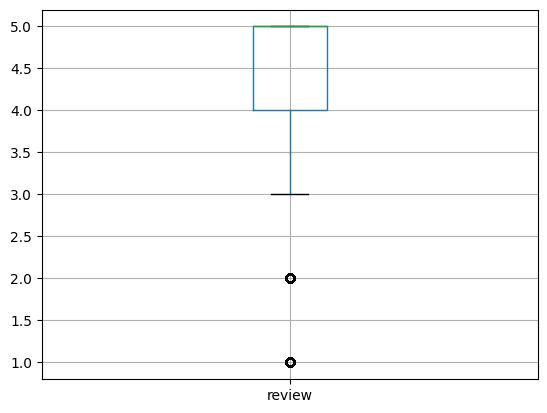

In [34]:
df_all_data_filtered_processed.boxplot(column=['review'])
plt.show()

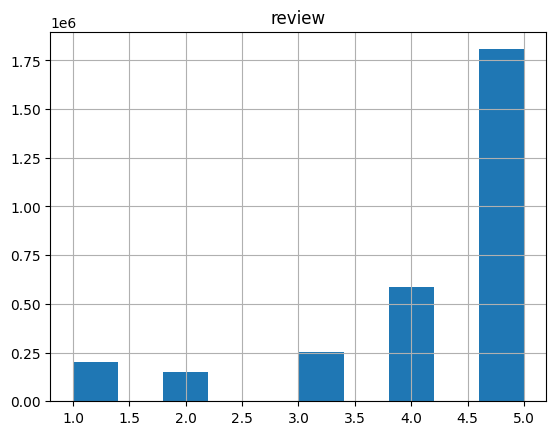

In [35]:
df_rating_processed.hist(column=['review'])
plt.show()

In [37]:
df_rating_processed[df_rating_processed['title']== 'The Hobbit']['review'].mean()

4.657131181038006

In [ ]:
df_rating_processed[df_rating_processed['Title']== 'The Hobbit']['review/score'].describe()

count    22023.000000
mean         4.657131
std          0.800452
min          1.000000
25%          5.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: review/score, dtype: float64

In [ ]:

df_rating_processed[df_rating_processed['Title']== 'Atlas Shrugged']['review/score'].describe()

count    12513.000000
mean         4.028690
std          1.418635
min          1.000000
25%          3.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: review/score, dtype: float64